# Exercise 6: Network inference from data (DL 20 October)

Lecturer: Antti Honkela

Your name: Christian Koetsier

Name of your pair: Bella Zhukova

In this exercise you will experiment with methods for inferring regulatory interactions.

If you have any questions, please post them to the Moodle discussion area!

# Task 1: Regulatory interaction inference with Gaussian Markov random field (2 pts)

In this task, you will generate a sparse Erdős–Rényi random graph, form the corresponding Gaussian Markov random field and study its covariance.

## a) Generating a graph.

Generate an undirected ER random graph for 12 genes using p=0.4. Construct a corresponding Gaussian Markov random field by forming the precision matrix which has non-zero elements corresponding to the edges of the graph. Make sure the precision matrix is positive definite by making the diagonal elements positive and sufficiently large compared to the other elements of the matrix.

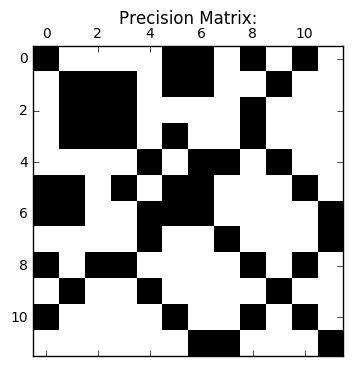

In [33]:
%matplotlib inline
# Import some useful modules
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import networkx as nx
import random
import math
import scipy

def getPrecisionMatrix(G, ):
    #Adjacenz matrix (undirected so both directions considered) precision matrix
    N = len(G.nodes())
    precisionMatrix = np.zeros((N,N))      
    for e in G.edges():
        covarianceValue = npr.normal(0,1)
        while covarianceValue == 0:
            covarianceValue = npr.normal(0,1)
        precisionMatrix[e[0]][e[1]] = covarianceValue
        precisionMatrix[e[1]][e[0]] = covarianceValue

    #Make sure the precision matrix is positive definite
    eigenVals = np.linalg.eigvals(precisionMatrix)  
    while any(val <= 0 for val in eigenVals):
        for i in range(len(precisionMatrix)):
            precisionMatrix[i][i] += 1
        eigenVals = np.linalg.eigvals(precisionMatrix) 
    return precisionMatrix

# Generate graph for 12 genes using p=0.4
G = nx.erdos_renyi_graph(12, 0.4)
precisionMatrix = getPrecisionMatrix(G)

# Plot the result
plt.figure(1)
plt.spy(precisionMatrix)
plt.title('Precision Matrix:')
plt.show()

# TODO: Check Result. And if its right what we did ;)

## b) The covariance matrix.
Compute the covariance matrix among the 12 genes from the precision matrix. Visualise the matrix. 

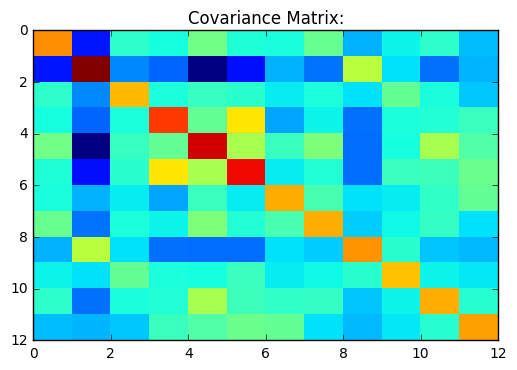

In [2]:
# Compute the covariance matrix
covarianceMatrix = np.linalg.inv(precisionMatrix)

# Plot the result
plt.figure(1)
plt.pcolor(covarianceMatrix)
plt.axis([0, len(covarianceMatrix), len(covarianceMatrix[0]), 0])
plt.title('Covariance Matrix:')
plt.show()

# TODO: Check Result. And if its right what we did ;)

**Can you spot the true connections?**

Answer:

NO! :) TODO:


## c) Estimating connections from the covariance.

Try setting a threshold for absolute values of the covariance matrix elements to distinguish between correct and false connections. Use the Hamming distance between the true and estimated connectivity matrices as a measure of accuracy.


smallestHammingDistance: 32
smallestHammingDistanceThreshold: 0.03000000000000002


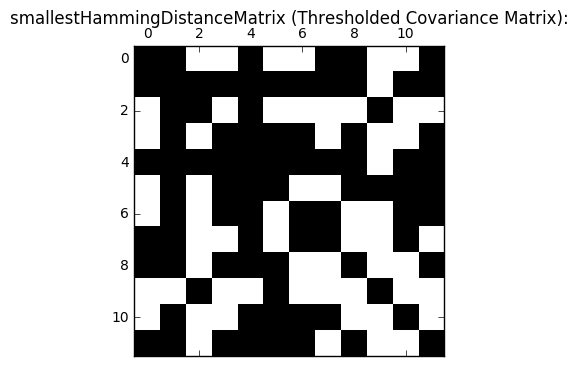

In [3]:
# Setting a threshold for absolute values of the covariance matrix elements
def getThresholdCovarianceCovarianzMatrix(matrix, threshold):
    thresholdCovarianceMatrix = np.copy(matrix)
    for row in range(len(thresholdCovarianceMatrix)):
        for col in range(len(thresholdCovarianceMatrix[0])):
            if abs(thresholdCovarianceMatrix[row][col]) < threshold:
                thresholdCovarianceMatrix[row][col] = 0
    return thresholdCovarianceMatrix

# Computing the Hamming distance 
def hammingDistance(M1,M2):
    hammingDistance = 0   
    for row in range(len(M1)):
        for col in range(len(M1[0])):  
            if M1[row][col] != 0 and M2[row][col] == 0:
                hammingDistance += 1
            if M2[row][col] != 0 and M1[row][col] == 0:
                hammingDistance += 1
    return hammingDistance

def getTheSmallestHammingDistance(covarianceMatrix,precisionMatrix):
    threshold = 0 
    thresholdStepSize = 0.001 #increase threshold every round by some small value
    smallestHammingDistance = 144 #most bad: 12*12=144 (every element differs)
    smallestHammingDistanceThreshold = 0
    smallestHammingDistanceMatrix = []
    numberOfRuns = math.ceil(np.max(covarianceMatrix)/thresholdStepSize) #run to the max value of the matrix
    for i in range(numberOfRuns):
        tmpThresholdCovarianceMatrix = getThresholdCovarianceCovarianzMatrix(covarianceMatrix,threshold)    
        tmpHammingDistance = hammingDistance(tmpThresholdCovarianceMatrix,precisionMatrix)
        if tmpHammingDistance < smallestHammingDistance:
            smallestHammingDistance = tmpHammingDistance
            smallestHammingDistanceThreshold = threshold
            smallestHammingDistanceMatrix = tmpThresholdCovarianceMatrix
        threshold += thresholdStepSize
    return smallestHammingDistance,smallestHammingDistanceThreshold,smallestHammingDistanceMatrix

# Format of result: [smallestHammingDistance,smallestHammingDistanceThreshold,smallestHammingDistanceMatrix]
result = getTheSmallestHammingDistance(covarianceMatrix,precisionMatrix)
smallestHammingDistance = result[0]
smallestHammingDistanceThreshold = result[1]
smallestHammingDistanceMatrix = result[2]

print('smallestHammingDistance:',smallestHammingDistance)
print('smallestHammingDistanceThreshold:',smallestHammingDistanceThreshold)

plt.figure(1)
plt.spy(smallestHammingDistanceMatrix)
plt.title('smallestHammingDistanceMatrix (Thresholded Covariance Matrix):')
plt.show()

# Try to find a really small hamming distance - uncomment to run it yourself, comment back afterwards
# 'HINT: Running this takes some amount of time!'
# smallestHammingDistance = 144 
# for i in range(1000):
#     G = nx.erdos_renyi_graph(12, 0.4)
#     precisionMatrix = getPrecisionMatrix(G)
#     covarianceMatrix = np.linalg.inv(precisionMatrix)
#     result = getTheSmallestHammingDistance(covarianceMatrix,precisionMatrix)
#     if result[0] < smallestHammingDistance:
#         smallestHammingDistance = result[0]
# print('smallestHammingDistance:',smallestHammingDistance)
        
# TODO: Check Result. And if its right what we did ;)       

### How small a Hamming distance can you achieve?
Answer:

My smallest was 10. See the above code (uncomment it and run it) TODO:

Hints:

* You can check if the precision matrix is positive definite using `np.linalg.eigvals()`. This returns the eigenvalues of the matrix which should all be positive. Eigenvalues of a symmetric matrix are always real. If you get complex eigenvalues, make sure the matrix is symmetric. (Precision and covariance matrices of Gaussian distributions are always symmetric.)
* You can force a matrix $\mathbf{A}$ to be positive definite by adding a diagonal term. If eigenvalues of $\mathbf{A}$ are $(\lambda_1, \dots, \lambda_n)$, eigenvalues of $\mathbf{A} + \alpha \mathbf{I}$ are $(\lambda_1+\alpha, \dots, \lambda_n+\alpha)$.
* `plt.spy()` function can be useful for exploring the sparsity pattern of matrices.
* Hamming distance of the binary connectivity matrices is the number of positions in which their values are different.

# Task 2: Inferring interactions from data (3 pts)

In this task, you will simulate observations from the Gaussian Markov random field model constructed in Task 1 and attempt to infer the network structure using those observations.

## a) Simulate data.
Simulate three multivariate normal observation data sets of sizes [25, 50, 100] with 0 mean using the covariance from Task 1.


In [4]:
# Arrays holding the simulation results
simulation1 = []
simulation2 = []
simulation3 = []

# Meanvector
mean = [0] * 12

# Simulate three multivariate normal observation
for i in range(25):
    simulation1.append(np.random.multivariate_normal(mean, covarianceMatrix))   
for i in range(50):
    simulation2.append(np.random.multivariate_normal(mean, covarianceMatrix))
for i in range(100):
    simulation3.append(np.random.multivariate_normal(mean, covarianceMatrix))
    
# TODO: Check Result. And if its right what we did ;)

## b) Visualise the correlation matrices.
Compute and visualise the correlation matrix among the 12 genes simulated. How small Hamming distance can you obtain with the different data sets using a suitable threshold?


simulation1 - smallestHammingDistance: 48 | smallestHammingDistanceThreshold: 0.35000000000000026
simulation2 - smallestHammingDistance: 46 | smallestHammingDistanceThreshold: 0.1470000000000001
simulation3 - smallestHammingDistance: 38 | smallestHammingDistanceThreshold: 0.2430000000000002


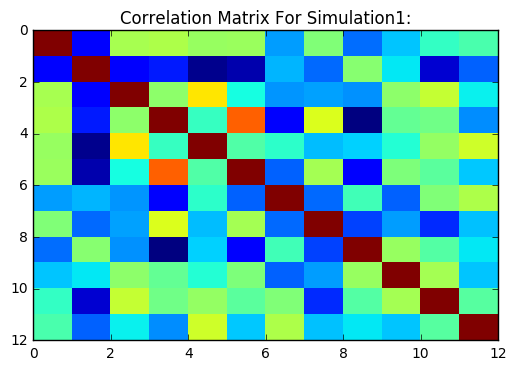

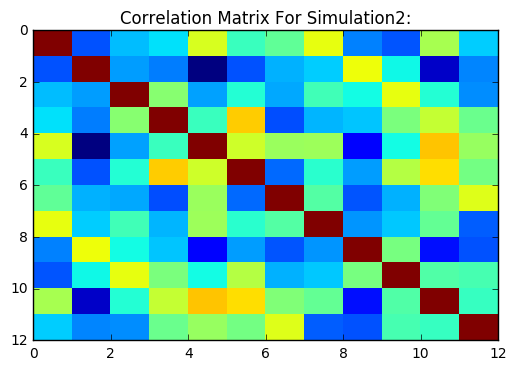

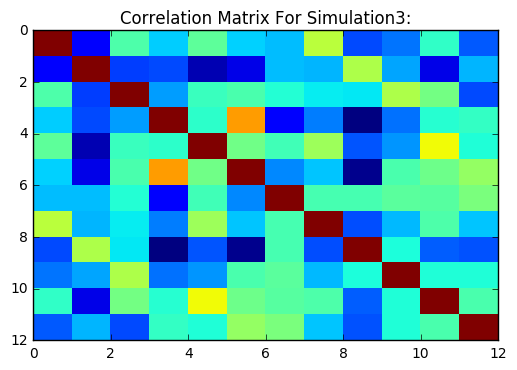

In [6]:
# Compute the correlation matrix among the 12 genes for each simulation 
correlationMatrix_simulation1 = np.corrcoef(np.transpose(np.array(simulation1)))
correlationMatrix_simulation2 = np.corrcoef(np.transpose(np.array(simulation2)))
correlationMatrix_simulation3 = np.corrcoef(np.transpose(np.array(simulation3)))

# Compute the smallest Hamming distance for each simulation 
result1 = getTheSmallestHammingDistance(correlationMatrix_simulation1,precisionMatrix)
result2 = getTheSmallestHammingDistance(correlationMatrix_simulation2,precisionMatrix)
result3 = getTheSmallestHammingDistance(correlationMatrix_simulation3,precisionMatrix)

# Print the results
print('simulation1 - smallestHammingDistance:',result1[0],'| smallestHammingDistanceThreshold:',result1[1])
print('simulation2 - smallestHammingDistance:',result2[0],'| smallestHammingDistanceThreshold:',result2[1])
print('simulation3 - smallestHammingDistance:',result3[0],'| smallestHammingDistanceThreshold:',result3[1])

# Plot the results 
plt.figure(1)
plt.pcolor(correlationMatrix_simulation1)
plt.axis([0, len(correlationMatrix_simulation1), len(correlationMatrix_simulation1[0]), 0])
plt.title('Correlation Matrix For Simulation1:')
plt.show()

plt.figure(2)
plt.pcolor(correlationMatrix_simulation2)
plt.axis([0, len(correlationMatrix_simulation2), len(correlationMatrix_simulation2[0]), 0])
plt.title('Correlation Matrix For Simulation2:')
plt.show()

plt.figure(3)
plt.pcolor(correlationMatrix_simulation3)
plt.axis([0, len(correlationMatrix_simulation3), len(correlationMatrix_simulation3[0]), 0])
plt.title('Correlation Matrix For Simulation3:')
plt.show()

# TODO: Check Result. And if its right what we did ;)

## c) Visualise the precision matrices.
Compute and visualise the inverse of the correlation matrix. How small Hamming distance can you now obtain with the different data sets using a suitable threshold?


simulation1 - smallestHammingDistance: 56 | smallestHammingDistanceThreshold: 0.4100000000000003
simulation2 - smallestHammingDistance: 38 | smallestHammingDistanceThreshold: 0.4170000000000003
simulation3 - smallestHammingDistance: 40 | smallestHammingDistanceThreshold: 0.2850000000000002


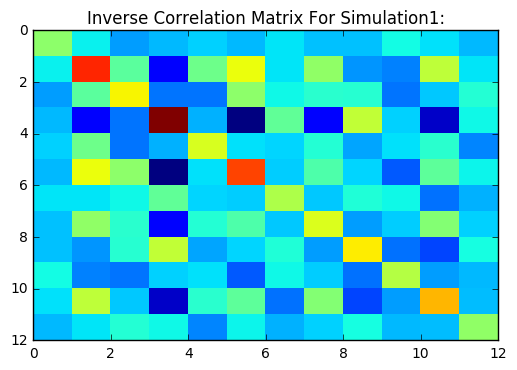

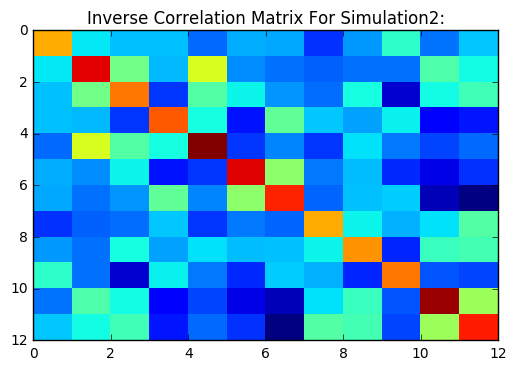

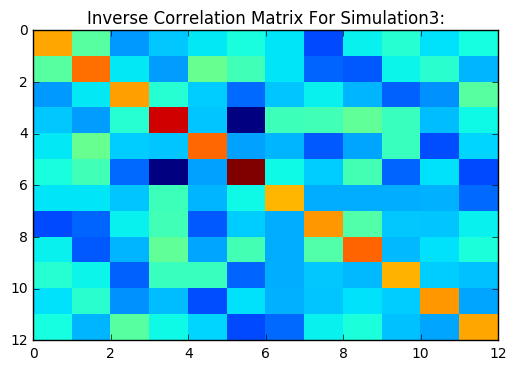

In [8]:
# Compute the inverse of the correlation matrix for each simulation 
InverseCorrelationMatrix_simulation1 = np.linalg.inv(correlationMatrix_simulation1)
InverseCorrelationMatrix_simulation2 = np.linalg.inv(correlationMatrix_simulation2)
InverseCorrelationMatrix_simulation3 = np.linalg.inv(correlationMatrix_simulation3)

# Compute the smallest Hamming distance for each simulation 
result1 = getTheSmallestHammingDistance(InverseCorrelationMatrix_simulation1,precisionMatrix)
result2 = getTheSmallestHammingDistance(InverseCorrelationMatrix_simulation2,precisionMatrix)
result3 = getTheSmallestHammingDistance(InverseCorrelationMatrix_simulation3,precisionMatrix)

# Print the results
print('simulation1 - smallestHammingDistance:',result1[0],'| smallestHammingDistanceThreshold:',result1[1])
print('simulation2 - smallestHammingDistance:',result2[0],'| smallestHammingDistanceThreshold:',result2[1])
print('simulation3 - smallestHammingDistance:',result3[0],'| smallestHammingDistanceThreshold:',result3[1])

# Plot the results 
plt.figure(1)
plt.pcolor(InverseCorrelationMatrix_simulation1)
plt.axis([0, len(InverseCorrelationMatrix_simulation1), len(InverseCorrelationMatrix_simulation1[0]), 0])
plt.title('Inverse Correlation Matrix For Simulation1:')
plt.show()

plt.figure(2)
plt.pcolor(InverseCorrelationMatrix_simulation2)
plt.axis([0, len(InverseCorrelationMatrix_simulation2), len(InverseCorrelationMatrix_simulation2[0]), 0])
plt.title('Inverse Correlation Matrix For Simulation2:')
plt.show()

plt.figure(3)
plt.pcolor(InverseCorrelationMatrix_simulation3)
plt.axis([0, len(InverseCorrelationMatrix_simulation3), len(InverseCorrelationMatrix_simulation3[0]), 0])
plt.title('Inverse Correlation Matrix For Simulation3:')
plt.show()

# TODO: Check Result. And if its right what we did ;)

## d) Structure learning using the graphical lasso.
Learn the structure using graphical lasso (`sklearn.covariance.graph_lasso()`). Try different values of the regularisation parameter. How good results in terms of the Hamming distance can you now obtain?


In [14]:
# http://scikit-learn.org/stable/modules/generated/sklearn.covariance.graph_lasso.html
# alpha - the regularization parameter: the higher alpha, the more regularization, the sparser the inverse covariance
import sklearn.covariance as sk

'HINT: Running this takes some amount of time!'

def getTheSmallestHammingDistanceUsingLasso(matrix):
    alpha = 0
    alphaStepSize = 0.001 #increase alpha every round by some small value
    smallestHammingDistance = 144 #most bad: 12*12=144 (every element differs)
    smallestHammingDistanceAlpha = 0
    smallestHammingDistanceCovarianceMatrix = []
    smallestHammingDistancePrecisionMatrix = []
    numberOfRuns = math.ceil(1/alphaStepSize) #run from alpha 0-1
    for i in range(numberOfRuns):
        covMatrix,preMatrix = sk.graph_lasso(matrix,alpha)
        #TODO: Which matrixes to compare?!?!
        result = getTheSmallestHammingDistance(covMatrix,preMatrix)
        if result[0] < smallestHammingDistance:
            smallestHammingDistance = result[0]
            smallestHammingDistanceAlpha = alpha
            smallestHammingDistanceCovarianceMatrix = covMatrix
            smallestHammingDistancePrecisionMatrix = preMatrix
        alpha += alphaStepSize
    return smallestHammingDistance,smallestHammingDistanceAlpha,smallestHammingDistanceCovarianceMatrix,smallestHammingDistancePrecisionMatrix

#TODO: Which matrixes to usere here??? - they are right?! >> Getting error....
#result1 = getTheSmallestHammingDistanceUsingLasso() #TODO:?? > InverseCorrelationMatrix_simulation1
#result2 = getTheSmallestHammingDistanceUsingLasso()
#result3 = getTheSmallestHammingDistanceUsingLasso()
        
print('simulation1 - smallestHammingDistance:',result1[0],'| smallestHammingDistanceAlpha:',result1[1])
print('simulation2 - smallestHammingDistance:',result2[0],'| smallestHammingDistanceAlpha:',result2[1])
print('simulation3 - smallestHammingDistance:',result2[0],'| smallestHammingDistanceAlpha:',result2[1])

simulation1 - smallestHammingDistance: 0 | smallestHammingDistanceAlpha: 0
simulation2 - smallestHammingDistance: 38 | smallestHammingDistanceAlpha: 0.4170000000000003
simulation3 - smallestHammingDistance: 38 | smallestHammingDistanceAlpha: 0.4170000000000003


## e) Comparison of the different approaches.

**How good results did you obtain with the different approaches?**

Answer:

Quite good, because testing all! TODO: Insert values if we managed to make it run :D :D

### Hints:

* See hints for Task 1 about positive definiteness of the covariance matrix.
* Graphical lasso is implemented in scikit-learn. You can install the package using the command "`pip3 install sklearn --user`" on the command line. If this does not work, more instructions are at: http://scikit-learn.org/

# Task 3: Inferring interactions from data II (2 pts)

In this task, you will simulate observations using a linear generative model:
$$ \mathbf{y_i} = \mathbf{A} \mathbf{x_i} + \epsilon_i. $$
Here $\mathbf{x_i}$ are TF expression levels (assumed to be random, following a Gaussian distribution), $\mathbf{A}$ is the connectivity matrix from TFs to target genes, $\mathbf{y_i}$ are the target gene expression levels and $\epsilon_i$ is Gaussian observation noise. Based on these data, you will attempt to infer the network structure.

## a) Generate the graph.
Generate a sparse Erdős–Rényi random connectivity graph from 3 TFs to 9 target genes and sample the random connection weights having this sparsity pattern.


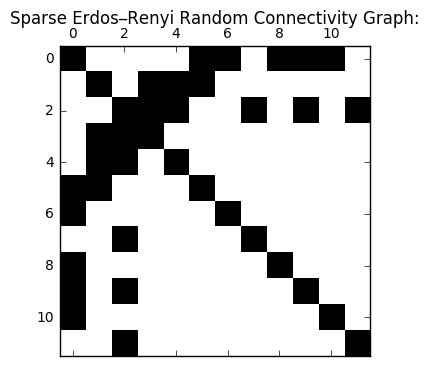

In [27]:
# HINT: 
# We implemented the graph based on the given example from the paper:
# 'On the inconsistency of l_1-penalised sparse precision matrix estimation', page five, figure 1.
# So there are only edges between the TFs and the genes and one gene has at least one edge to any TF.
def getSparseErdosRenyiGraph(edgeProb, numTF, numGenes):
    transcriptionFactors = [i for i in range(numTF)]    
    genes = [i for i in range(numTF,numTF+numGenes)]
    
    sparseErdosRenyiGraph = nx.Graph()
    sparseErdosRenyiGraph.add_nodes_from(transcriptionFactors)
    sparseErdosRenyiGraph.add_nodes_from(genes)
        
    for g in genes:    
        targetCount = 0
        while targetCount == 0:
            for tf in transcriptionFactors:
                r = random.random()
                if r <= edgeProb:
                    sparseErdosRenyiGraph.add_edge(tf,g)
                    targetCount += 1
    return sparseErdosRenyiGraph

# Generate a sparse Erdos–Renyi random connectivity graph
G = getSparseErdosRenyiGraph(0.4, 3, 9)
precisionMatrix = getPrecisionMatrix(G) 

# Plot the graph
plt.spy(precisionMatrix)
plt.title('Sparse Erdos–Renyi Random Connectivity Graph:')
plt.show()

# TODO: Check Result. And if its right what we did ;)
# TODO: Sometimes not very common it has a bug, that there is no edge to one of the TFs for all genes!!!

## b) Simulate the TFs and targets.
Simulate 3 data sets following the above connectivity graph and model with 3 TFs and 9 target genes, having [25, 50, 100] samples. You can simulate $\mathbf{x_i}$ from $\mathcal{N}(0, 1)$ and $\epsilon_i$ from $\mathcal{N}(0, 0.1^2)$.


In [29]:
# Arrays holding the simulation results 
simulation1 = []
simulation2 = []
simulation3 = []

# Meanvector 
mean = [0] * 12  

# Simulate
for i in range(25):
    simulation1.append(precisionMatrix@[np.random.normal(0,1) for i in range(len(precisionMatrix))]+[np.random.normal(0,0.1**2) for i in range(len(precisionMatrix))])   
for i in range(50):
    simulation2.append(precisionMatrix@[np.random.normal(0,1) for i in range(len(precisionMatrix))]+[np.random.normal(0,0.1**2) for i in range(len(precisionMatrix))])   
for i in range(100):
    simulation3.append(precisionMatrix@[np.random.normal(0,1) for i in range(len(precisionMatrix))]+[np.random.normal(0,0.1**2) for i in range(len(precisionMatrix))])   
    
# TODO: Check Result. And if its right what we did ;)

## c) Correlation matrix analysis.
Form a data set by concatenating the TFs and targets. Compute and visualise the correlation matrix among the 12 genes. How small Hamming distance between the true network and the estimated network can you obtain?


simulation1 - smallestHammingDistance: 12 | smallestHammingDistanceThreshold: 0.43900000000000033
simulation2 - smallestHammingDistance: 14 | smallestHammingDistanceThreshold: 0.2930000000000002
simulation3 - smallestHammingDistance: 8 | smallestHammingDistanceThreshold: 0.2700000000000002


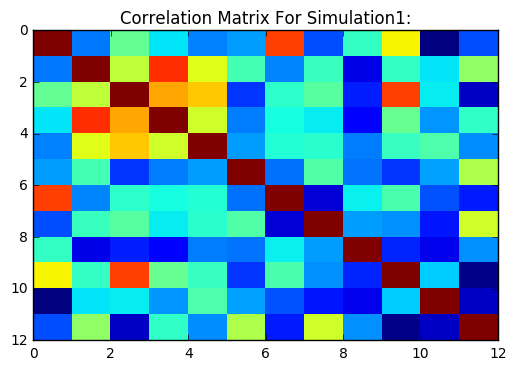

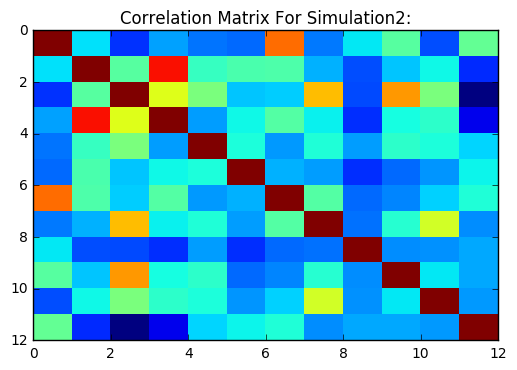

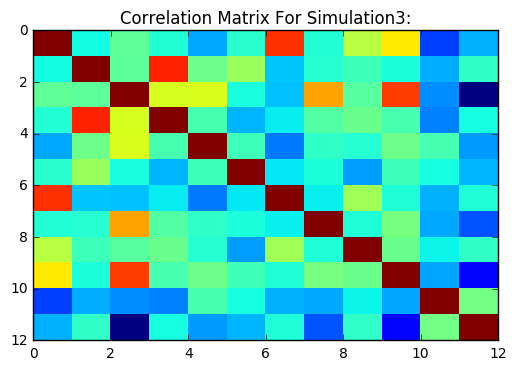

In [30]:
# Compute the correlation matrix among the 12 genes for each simulation 
correlationMatrix_simulation1 = np.corrcoef(np.transpose(np.array(simulation1)))
correlationMatrix_simulation2 = np.corrcoef(np.transpose(np.array(simulation2)))
correlationMatrix_simulation3 = np.corrcoef(np.transpose(np.array(simulation3)))

# Compute the smallest Hamming distance for each simulation 
result1 = getTheSmallestHammingDistance(correlationMatrix_simulation1,precisionMatrix)
result2 = getTheSmallestHammingDistance(correlationMatrix_simulation2,precisionMatrix)
result3 = getTheSmallestHammingDistance(correlationMatrix_simulation3,precisionMatrix)

# Print the results
print('simulation1 - smallestHammingDistance:',result1[0],'| smallestHammingDistanceThreshold:',result1[1])
print('simulation2 - smallestHammingDistance:',result2[0],'| smallestHammingDistanceThreshold:',result2[1])
print('simulation3 - smallestHammingDistance:',result3[0],'| smallestHammingDistanceThreshold:',result3[1])

# Plot the results 
plt.figure(1)
plt.pcolor(correlationMatrix_simulation1)
plt.axis([0, len(correlationMatrix_simulation1), len(correlationMatrix_simulation1[0]), 0])
plt.title('Correlation Matrix For Simulation1:')
plt.show()

plt.figure(2)
plt.pcolor(correlationMatrix_simulation2)
plt.axis([0, len(correlationMatrix_simulation2), len(correlationMatrix_simulation2[0]), 0])
plt.title('Correlation Matrix For Simulation2:')
plt.show()

plt.figure(3)
plt.pcolor(correlationMatrix_simulation3)
plt.axis([0, len(correlationMatrix_simulation3), len(correlationMatrix_simulation3[0]), 0])
plt.title('Correlation Matrix For Simulation3:')
plt.show()

# TODO: Check Result. And if its right what we did ;)
# TODO: What is meant by: 'Form a data set by concatenating the TFs and targets.'

## d) Precision matrix analysis.
Compute and visualise the inverse of the correlation matrix. How well can you now find the true connections in terms of the Hamming distance?


simulation1 - smallestHammingDistance: 31 | smallestHammingDistanceThreshold: 94.72000000008822
simulation2 - smallestHammingDistance: 31 | smallestHammingDistanceThreshold: 95.89400000009383
simulation3 - smallestHammingDistance: 31 | smallestHammingDistanceThreshold: 72.10899999998026


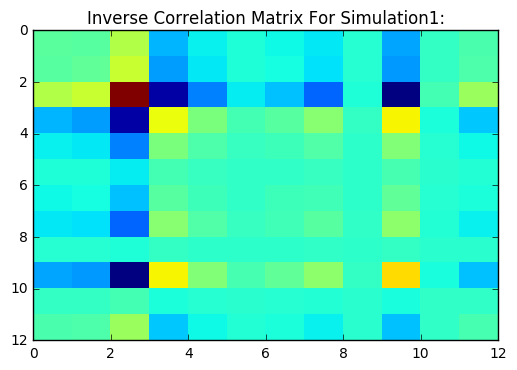

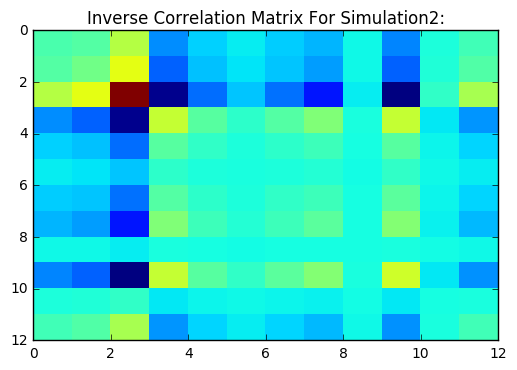

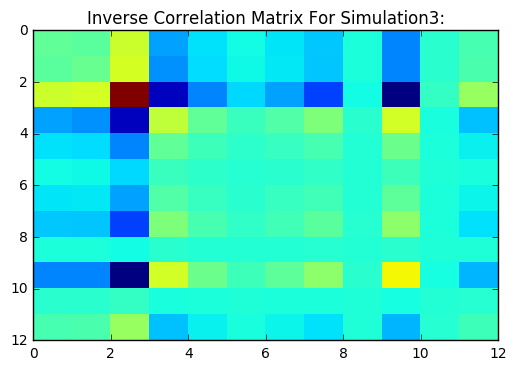

In [31]:
'HINT: Running this takes some amount of time!'

# Compute the inverse of the correlation matrix for each simulation
InverseCorrelationMatrix_simulation1 = np.linalg.inv(correlationMatrix_simulation1)
InverseCorrelationMatrix_simulation2 = np.linalg.inv(correlationMatrix_simulation2)
InverseCorrelationMatrix_simulation3 = np.linalg.inv(correlationMatrix_simulation3)

# Compute the smallest Hamming distance for each simulation 
result1 = getTheSmallestHammingDistance(InverseCorrelationMatrix_simulation1,precisionMatrix)
result2 = getTheSmallestHammingDistance(InverseCorrelationMatrix_simulation2,precisionMatrix)
result3 = getTheSmallestHammingDistance(InverseCorrelationMatrix_simulation3,precisionMatrix)

# Print the results
print('simulation1 - smallestHammingDistance:',result1[0],'| smallestHammingDistanceThreshold:',result1[1])
print('simulation2 - smallestHammingDistance:',result2[0],'| smallestHammingDistanceThreshold:',result2[1])
print('simulation3 - smallestHammingDistance:',result3[0],'| smallestHammingDistanceThreshold:',result3[1])

# Plot the results 
plt.figure(1)
plt.pcolor(InverseCorrelationMatrix_simulation1)
plt.axis([0, len(InverseCorrelationMatrix_simulation1), len(InverseCorrelationMatrix_simulation1[0]), 0])
plt.title('Inverse Correlation Matrix For Simulation1:')
plt.show()

plt.figure(2)
plt.pcolor(InverseCorrelationMatrix_simulation2)
plt.axis([0, len(InverseCorrelationMatrix_simulation2), len(InverseCorrelationMatrix_simulation2[0]), 0])
plt.title('Inverse Correlation Matrix For Simulation2:')
plt.show()

plt.figure(3)
plt.pcolor(InverseCorrelationMatrix_simulation3)
plt.axis([0, len(InverseCorrelationMatrix_simulation3), len(InverseCorrelationMatrix_simulation3[0]), 0])
plt.title('Inverse Correlation Matrix For Simulation3:')
plt.show()

# TODO: Check Result. And if its right what we did ;)

### Hints:

* When computing covariances, it can be useful to check the shape of the result that you are computing it the right way. You can then transpose the data (`X` -> `X.T`) if necessary.

# Task 4: Inferring interactions from dynamic simulations (3 pts)

In this task, you will simulate observations using the following dynamical model:
$$ \frac{d \mathbf{x}(t)}{dt} = \sigma(\mathbf{A} \mathbf{x}) - \delta \mathbf{x} + \gamma, $$
where $\mathbf{x}$ are the gene expression levels, $\mathbf{A}$ is the connectivity matrix (connecting only TFs to TFs and TFs to targets), $\sigma(x) = 1/(1+e^{-x})$ is a sigmoid function, $\delta$ are the mRNA degradation rates and $\gamma$ are constant external inputs (affecting only TFs).

## a) Simulate the system
Implement a function for simulating from the above system. You can use `scipy.integrate.odeint()` to numerically solve the differential equation given a suitable non-negative initial state.

Pick a plausible connectivity matrix with 3 TFs and 9 target genes that includes different combinations of TFs regulating different targets and also some negative connection weights. Simulate the system with a constant non-negative external input and $\delta = 1$ and visualise the results.


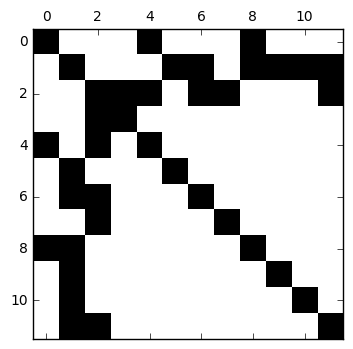

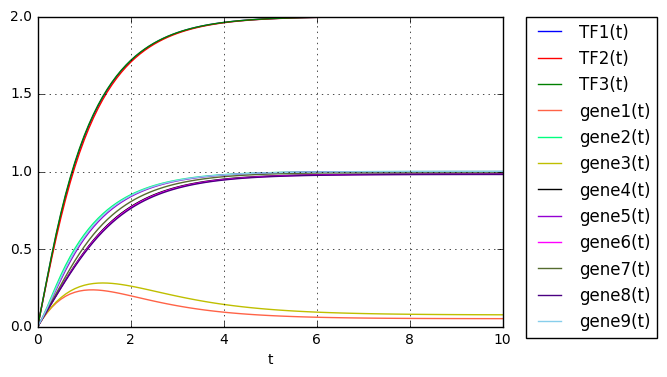

In [36]:
# TODO: Maybe some comments ;) and clean up code...

def sigmoid(x):
    return 1/(1 + math.exp(-x))

def func(x, t, A, gamma):
    x = np.array(x)
    N = len(A)  
    result = np.zeros(N)
    Ax = A @ x
    for i in range(N):
        result[i] = sigmoid(Ax[i]) - 1 * x[i] + gamma[i]
    return result

def simulate(A, gammaConstant, plot):
    t = np.linspace(0, 10, 101)
    x0 = np.zeros(len(A)) # TODO: generate random?
#     x0 = [random.random() for i in range(len(precisionMatrix))]
    
    gamma = np.zeros(len(A))
    for i in range(3):
        gamma[i] = gammaConstant[i] # affects only TFs
    
    simulation = scipy.integrate.odeint(func, x0, t, args=(A, gamma))
    
    # plotting
    if plot:
        plt.plot(t, simulation[:, 0], 'b', label='TF1(t)')
        plt.plot(t, simulation[:, 1], 'r', label='TF2(t)')
        plt.plot(t, simulation[:, 2], 'g', label='TF3(t)')

        plt.plot(t, simulation[:, 3], 'tomato', label='gene1(t)')
        plt.plot(t, simulation[:, 4], 'springgreen', label='gene2(t)')
        plt.plot(t, simulation[:, 5], 'y', label='gene3(t)')
        plt.plot(t, simulation[:, 6], 'k', label='gene4(t)')
        plt.plot(t, simulation[:, 7], 'darkviolet', label='gene5(t)')
        plt.plot(t, simulation[:, 8], 'magenta', label='gene6(t)')
        plt.plot(t, simulation[:, 9], 'darkolivegreen', label='gene7(t)')
        plt.plot(t, simulation[:, 10], 'indigo', label='gene8(t)')
        plt.plot(t, simulation[:, 11], 'skyblue', label='gene9(t)')

        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        #TODO: Set plot title!
        plt.xlabel('t')
        plt.grid()
        plt.show()
        
    return simulation


# #Format: edgeProb, numTF, numGenes
G = getSparseErdosRenyiGraph(0.4, 3, 9)
precisionMatrix = getPrecisionMatrix(G) 

# TODO: if diagonal should be 0 or eigen values >0?
# for i in range(len(precisionMatrix)):
#     precisionMatrix[i][i] = 0

#TODO: Set plot title!
plt.spy(precisionMatrix)
plt.show()
#TODO: and sample the random connection weights having this sparsity pattern.


# t : array, A sequence of time points for which to solve for y. The initial value point should be the first element of this sequence.
simulation = simulate(precisionMatrix, [1,1,1], True)
# simulation1.append(precisionMatrix@[np.random.normal(0,1) for i in range(len(precisionMatrix))]+[np.random.normal(0,0.1**2) for i in range(len(precisionMatrix))])   



# TODO: Check Result. And if its right what we did ;)

## b) Simulate with different inputs
Simulate the system with number of non-negative random external inputs until it reaches steady state. What can you see?


Simulation for gamma: [0.4593700307077455, 0.4593700307077455, 0.4593700307077455]


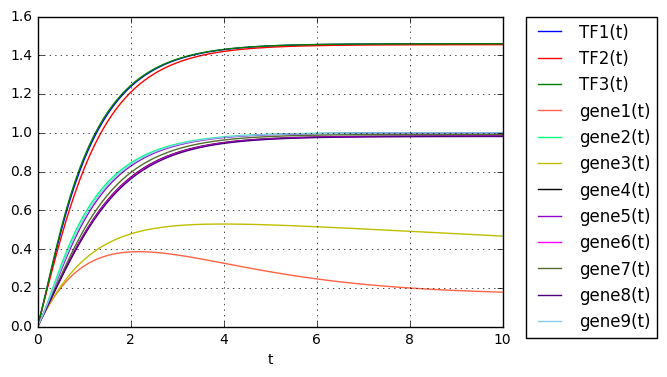

Simulation for gamma: [1.9140702468036663, 1.9140702468036663, 1.9140702468036663]


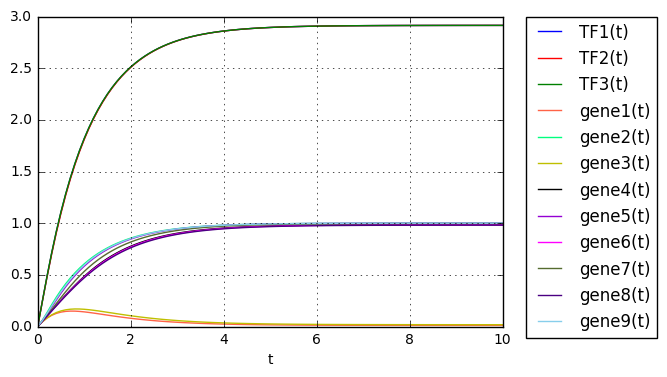

Simulation for gamma: [1.291851573790393, 1.291851573790393, 1.291851573790393]


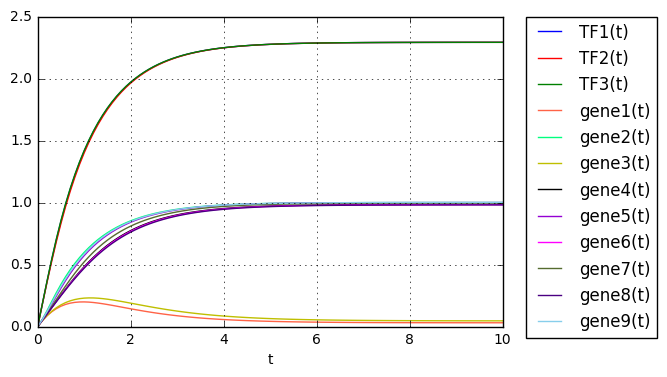

Simulation for gamma: [0.8548514905505498, 0.8548514905505498, 0.8548514905505498]


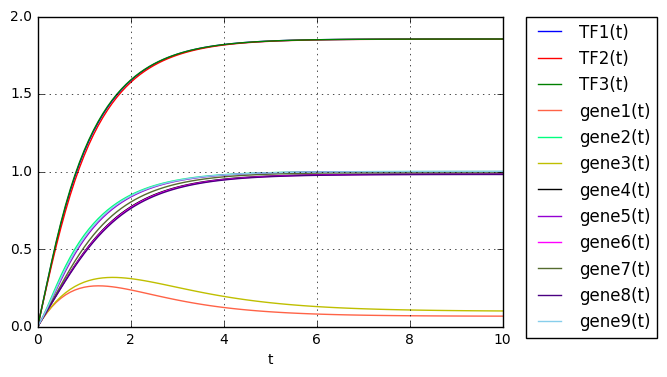

Simulation for gamma: [0.012260712058896006, 0.012260712058896006, 0.012260712058896006]


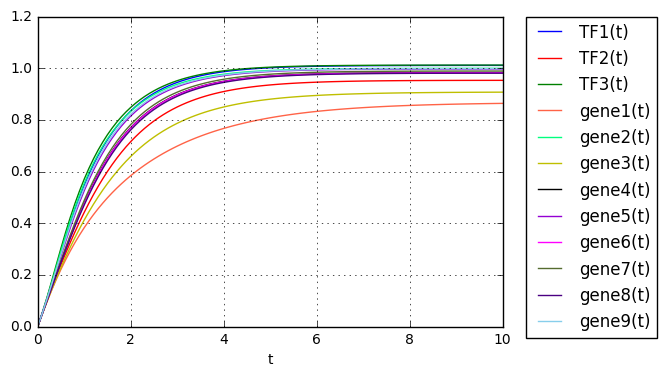

In [37]:
# Simulate the system with number of non-negative random external inputs
for i in range(5):
    # TODO: different gammas for each run or in the run?
    # gamma = [random.random() for i in range(3)]
    gamma = random.random() * 2
    print('Simulation for gamma:', [gamma, gamma, gamma])
    simulation = simulate(precisionMatrix, [gamma, gamma, gamma], True)

# What can you see?
# Answer: TODO...
    
# TODO: Check Result. And if its right what we did ;)

## c) Infer the network structure
Compute the correlations and inverse covariance for the combined steady-state measurements from [10, 20, 40] simulations. Can you recover the true connections?

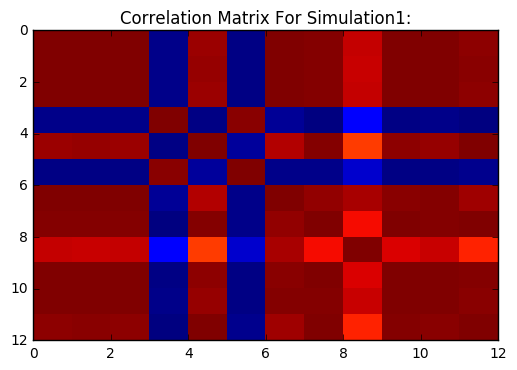

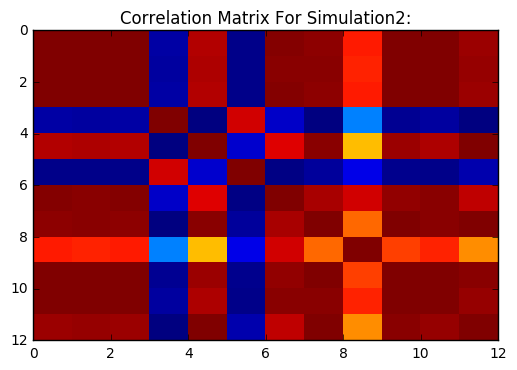

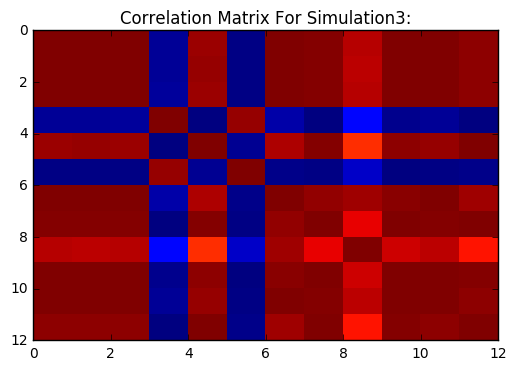

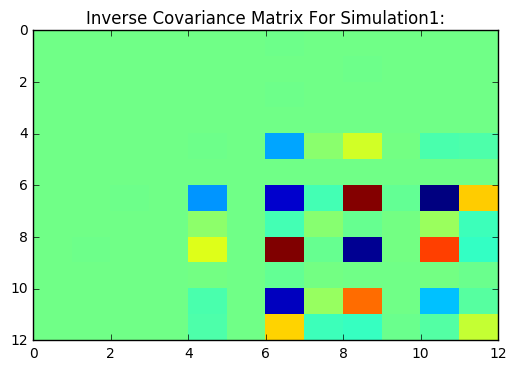

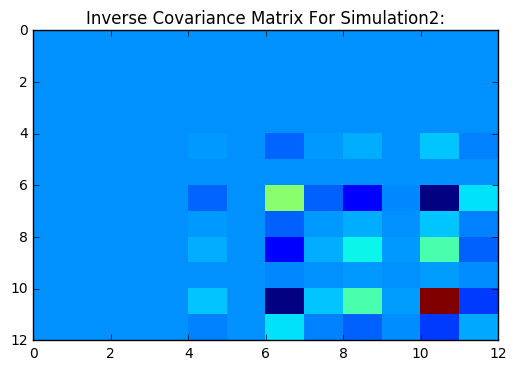

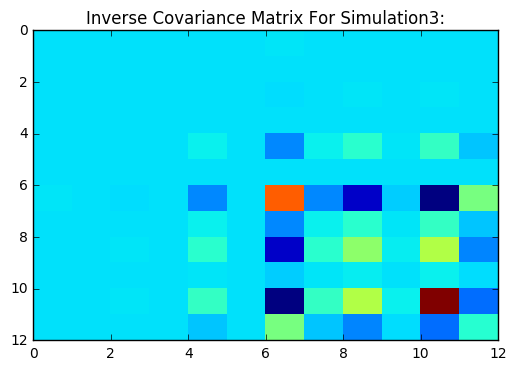

In [39]:
# Arrays holding the simulation results 
simulation1 = []
simulation2 = []
simulation3 = []

# Simulate
for i in range(10):
    # TODO: different gammas for each run or in the run?
    # gamma = [random.random() for i in range(3)]
    gamma = random.random()
    simulation = simulate(precisionMatrix, [gamma, gamma, gamma], False)
    simulation1.append(simulation[-1])   
for i in range(20):
    # TODO: different gammas for each run or in the run?
    # gamma = [random.random() for i in range(3)]
    gamma = random.random()
    simulation = simulate(precisionMatrix, [gamma, gamma, gamma], False)
    simulation2.append(simulation[-1])   
for i in range(40):
    # TODO: different gammas for each run or in the run?
    # gamma = [random.random() for i in range(3)]
    gamma = random.random()
    simulation = simulate(precisionMatrix, [gamma, gamma, gamma], False)
    simulation3.append(simulation[-1])   

# Compute the correlations for the combined steady-state measurements
correlationMatrix_simulation1 = np.corrcoef(np.transpose(np.array(simulation1)))
correlationMatrix_simulation2 = np.corrcoef(np.transpose(np.array(simulation2)))
correlationMatrix_simulation3 = np.corrcoef(np.transpose(np.array(simulation3)))

# Plot the results
plt.figure(1)
plt.pcolor(correlationMatrix_simulation1)
plt.axis([0, len(correlationMatrix_simulation1), len(correlationMatrix_simulation1[0]), 0])
plt.title('Correlation Matrix For Simulation1:')
plt.show()

plt.figure(2)
plt.pcolor(correlationMatrix_simulation2)
plt.axis([0, len(correlationMatrix_simulation2), len(correlationMatrix_simulation2[0]), 0])
plt.title('Correlation Matrix For Simulation2:')
plt.show()

plt.figure(3)
plt.pcolor(correlationMatrix_simulation3)
plt.axis([0, len(correlationMatrix_simulation3), len(correlationMatrix_simulation3[0]), 0])
plt.title('Correlation Matrix For Simulation3:')
plt.show()

# TODO: why this task is different to other the other previous tasks
# Compute the inverse covariance for the combined steady-state measurements
InverseCovarianceMatrix_simulation1 = np.linalg.inv(np.cov(np.transpose(np.array(simulation1))))
InverseCovarianceMatrix_simulation2 = np.linalg.inv(np.cov(np.transpose(np.array(simulation2))))
InverseCovarianceMatrix_simulation3 = np.linalg.inv(np.cov(np.transpose(np.array(simulation3))))

# Plot the results
plt.figure(4)
plt.pcolor(InverseCovarianceMatrix_simulation1)
plt.axis([0, len(InverseCovarianceMatrix_simulation1), len(InverseCovarianceMatrix_simulation1[0]), 0])
plt.title('Inverse Covariance Matrix For Simulation1:')
plt.show()

plt.figure(5)
plt.pcolor(InverseCovarianceMatrix_simulation2)
plt.axis([0, len(InverseCovarianceMatrix_simulation2), len(InverseCovarianceMatrix_simulation2[0]), 0])
plt.title('Inverse Covariance Matrix For Simulation2:')
plt.show()

plt.figure(6)
plt.pcolor(InverseCovarianceMatrix_simulation3)
plt.axis([0, len(InverseCovarianceMatrix_simulation3), len(InverseCovarianceMatrix_simulation3[0]), 0])
plt.title('Inverse Covariance Matrix For Simulation3:')
plt.show()

# TODO: Check Result. And if its right what we did ;)

**How well can you recover the true connections?**

Your answer:

NO! :) TODO

### Background on Task 4

The use of sigmoid function in the dynamics as in this task is not very common. It has clear advantages over plain linear model (saturation of transcription rate to a fixed maximum, possibly easier stability guarantees, possibility to model repression), but the presented formulation still cannot realistically model combinatorial regulation, and it makes model inference much more difficult than linear differential equations.